## The Lake Model meets US data

Recall the setting and some standard language that helps us keep sight of how various
pieces of our analysis fit together.

* A **statistical model** is a joint probability density $f(Y; \theta)$ for a sequence $Y$ of random variables indexed by a list $\theta$ of parameters.

* The **direct problem** is to draw a random sample $y$ from the statistical model
$f(Y; \theta)$ for an assumed value of the parameter vector $\theta$.

* The **inverse problem** is to take a set of data $\tilde y$ assumed to be drawn from
$f(Y;\theta)$ and to use them to make inferences about the unknown parameter vector $\theta$.

Thus, the **direct problem** is to construct a **simulation** of model $f(Y;\theta)$
for a given $\theta$.  

* Other names for  the simulated data $ y$ are *artificial data* or *fake data*

The **inverse problem** is also called the **parameter estimation problem**.

The **direct problem** takes parameters as inputs and artificial or fake data as outputs

The **inverse problem** takes real world data (i.e., "the observations") as inputs and statements about parameters as outputs.

Both problems assume the same statistical model $f(Y; \theta)$.


Tools that allow us to solve the **direct problem** often turn out to be helpful in 
solving the **inverse problem**.


**Application to lake model**

Please keep this framework in mind as we use various versions of the  "lake model"
to try to understand employment and unemployment rates over time.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

# for reproducibility
np.random.seed(42)
random.seed(42)

## Recent unemployment rates in the US

The BLS data show a large shift in the employment/unemployment numbers in the US in early 2020

Let's remind ourselves what these data look like:

In [2]:
df_bls = pd.read_csv("bls_recessions_data.csv")
df_bls["labor_supply"] = df_bls.eval("employed + unemployed")
df_bls["employed_pct"] = df_bls.eval("employed / labor_supply")
df_bls["unemployed_pct"] = df_bls.eval("unemployed / labor_supply")
df_bls.head()

,recession,days_from,ee,employed,eu,ue,unemployed,uu,laborforce,months_from,labor_supply,employed_pct,unemployed_pct
0,gr,30,0.955834,144479,0.013822,0.317568,7400,0.478649,151879,-35,151879,0.951277,0.048723
1,gr,58,0.958678,145323,0.010583,0.312599,6913,0.522494,152236,-34,152236,0.954590,0.045410
2,gr,89,0.962828,145297,0.010193,0.291182,6532,0.535671,151829,-33,151829,0.956978,0.043022
3,gr,119,0.960751,145864,0.010290,0.288622,6486,0.494295,152350,-32,152350,0.957427,0.042573
4,gr,150,0.950496,146958,0.012868,0.250994,7295,0.432625,154253,-31,154253,0.952708,0.047292


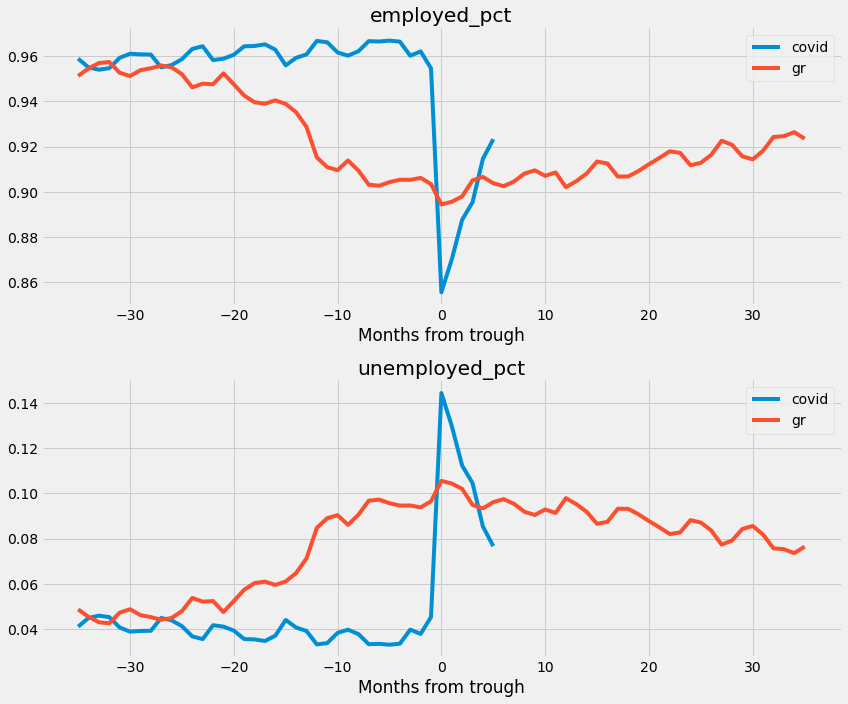

In [3]:
def plot_recession_data(df):
    """
    Plot the employment and unemployment percents contained in df
    
    The x value is `months_from` with interpretation of the months
    from the trough of a recession. A negative number indicates a 
    date before the trough
    
    There will be subplots for employment and unemployment percentages
    
    There will be one line per subplot for each unique value of the 
    `recession` column
    
    Paramters
    ---------
    df: pd.DataFrame
        A pandas DataFrame containing the labor market data to be plotted
        
    Returns
    -------
    fig: matplotlib.pyplot.Figure
        A matplotlib Figure with the chart
    """
    # create figure with two subplots, one for emp, one for unemp
    fig, axs = plt.subplots(2, 1, figsize=(12, 10))
    
    # list of columns to plot
    columns = ["employed_pct", "unemployed_pct"]
    for ax, col in zip(axs, columns):        
        # loop over data and plot column on axes for each recession
        for recession, data in df.groupby("recession"):
            data.plot(x="months_from", y=col, ax=ax, label=recession)
        # beautify axes
        ax.set_title(col)
        ax.spines["right"].set_visible(False)
        ax.spines["top"].set_visible(False)
        ax.set_xlabel("Months from trough")
    fig.tight_layout()
    return fig

plot_recession_data(df_bls);

We've been using a lake model with two parameters:

- $\alpha$: probability of unemployed worker finding a job. Called the *job finding rate*
- $\beta$: probability of employed worker losing a job. Called the *job separation rate*

And one state variable:

- $s$: a  $2 \times 1$ vector of  percentages of unemployed and employed workers, respectively.

With constant values  of $\alpha$ and $\beta$, our model cannot generate sudden large changes in the unemployment rate.

Let's look at an example using code from `v1_employment_model.py`

In [4]:
import v1_employment_model as emp
import numpy as np

We will first create a new Python class that we'll use throughout this lesson

The class will help us:

- Keep track of model parameters
- Simulate a panel of workers
- Plot simulated results alongside data from BLS

The class looks long, but most of the lines are docstrings and comments

We'll review it one step at a time and it will be clear

In [5]:
class LakeModelSimulator:
    def __init__(self, N:int = 5000, s_0: np.ndarray=np.array([0.0237, 0.9763])):
        """
        Helper class that can simulate individuals working in an economy
        where job loss and finding is governed by the Lake model
        
        Parameters
        ----------
        
        N: int
            The number of individuals in the simulated panels
        s_0: np.ndarray(float, ndim=1, size=2)
            The initial distribution of [unemployed, employed] workers
            in the economy. These should be two numbers between [0, 1]
            that sum to one. The default value is the long run value of the
            employment to unemployment ratio computed using data from the
            CPS
        """
        self.N = N
        self._s_0 = s_0
    
    # define s_0 as Python property so we can ensure it cannot be 
    # set to an inappropriate value
    
    # define a `get_s_0` method. lm.s_0
    def get_s_0(self) -> np.ndarray:
        return self._s_0
        
    # and a set_s_0 method
    def set_s_0(self, new_s_0: np.ndarray):
        """
        Change the value of s_0
        
        Parameters
        ----------
        new_s_0: np.ndarray
            The new value of s_0 that should be used in future simulations
        """
        assert len(new_s_0) == 2
        assert abs(sum(new_s_0) - 1.0) < 1e-10
        self._s_0 = np.asarray(new_s_0)
    
    # combine the two to create the official s_0
    s_0 = property(get_s_0, set_s_0)
    
    def combine_with_bls_data(self, df_sim: pd.DataFrame, df_bls: pd.DataFrame=df_bls) -> pd.DataFrame:
        """
        Combine the simulated data from `df_sim` with the BLS data in
        `df_bls` and plot the percent of workers employed and unemployed
        
        Parameters
        ----------
        df_sim: pd.DataFrame
            The simulated DataFrame constructed by this class
        
        df_bls: pd.DataFrame
            The DataFrame containing official data from the BLS
            
        Returns
        -------
        df: pandas.DataFrame
            A DataFrame containing the combined data
            
        Notes
        -----
        Both DataFrames should have at least the following columns:
        ["months_from", "employed_pct", "unemployed_pct", "recession"]
        
        Also, the `months_from` column in `df_sim` will be modified as
        `df_sim["months_from"] -= df_bls["months_from"].min()` to align
        dates
        """
        # adjust the months_from on the simulated data by -35 to match
        # the bls data
        df_sim_plot = df_sim.copy()
        df_sim_plot["months_from"] -= 35
        df = pd.concat([df_sim_plot, df_bls], ignore_index=True)
        return df
    
    def simulate_panel(
            self,
            alpha: np.ndarray, 
            beta: np.ndarray,
        ) -> pd.DataFrame:
        """
        Simulate a panel of employees whose transitions in and out
        of employment are goverened by the lake model with parameters
        alpha and beta

        Parameters
        ----------
        alpha: np.array(float, ndim=1)
            The probability that an individual goes from
            unemployed to employed
        beta: np.array(float, ndim=1)
            The probability that an individual goes from
            employed to unemployed

        Returns
        -------
        df: pd.DataFrame
            A pandas DataFrame in the same form as the `df_bls` DataFrame
            from above. In particular, it has columns 
            ["months_from", "employed_pct", "unemployed_pct", "recession"]
        """
        # workers is N x T array of (0, 1)
        workers = emp.simulate_employment_cross_section(
            alpha, beta, self.s_0, N=self.N
        )
        T = workers.shape[1]

        # sum over all workers to get count of 
        # how many of the 500 workers were employed in each period
        employed = workers.sum(axis=0)

        # put into dataframe with columns expected by the plot function
        return (
            pd.DataFrame(dict(
                months_from=np.arange(T),
                employed_pct=employed/self.N,
                unemployed_pct=1 - employed/self.N,
            )).assign(recession="model")
        )
    
    def simulate_panel_fixed_alpha_beta(
            self,
            alpha_0: float, 
            beta_0: float, 
            T:int = 72,
        ) -> pd.DataFrame:
        """
        Helper function to simulate Lake model when alpha and beta
        are constant

        Parameters
        ----------
        alpha: float
            The probability that an individual goes from
            unemployed to employed
        beta: float
            The probability that an individual goes from
            employed to unemployed
        T: int
            The number of periods for which to simulate. by default this 
            is 60 (to match length of 'gr' subset of `df_bls`)

        Returns
        -------
        df: pd.DataFrame
            A pandas DataFrame in the same form as the `df_bls` DataFrame
            from above. In particular, it has columns 
            ["months_from", "employed_pct", "unemployed_pct", "recession"]

        See Also
        --------

        See also the method `simulate_employment_panel_df`
        """
        alpha_vec = np.ones(T) * alpha_0
        beta_vec = np.ones(T) * beta_0
        return self.simulate_panel(alpha_vec, beta_vec)

Now let's try out this class with reasonable "normal time" parameters for $\alpha$ and $\beta$

We'll call these normal-time parameters $\bar{\alpha} = 0.37$ and $\bar{\beta} = 0.01$ and refer to them as the steady state parameters

These values were estimated using CPS data in an earlier lecture

Also note that we'll start with $s_0 = \bar{s} = [0.0237, 0.9763]$, which are implied steady state percentages of unemployed and employed workers (also estimated previously using CPS data)

In [6]:
alpha_bar = 0.37
beta_bar = 0.01
s_bar = np.array([0.0237, 0.9763])

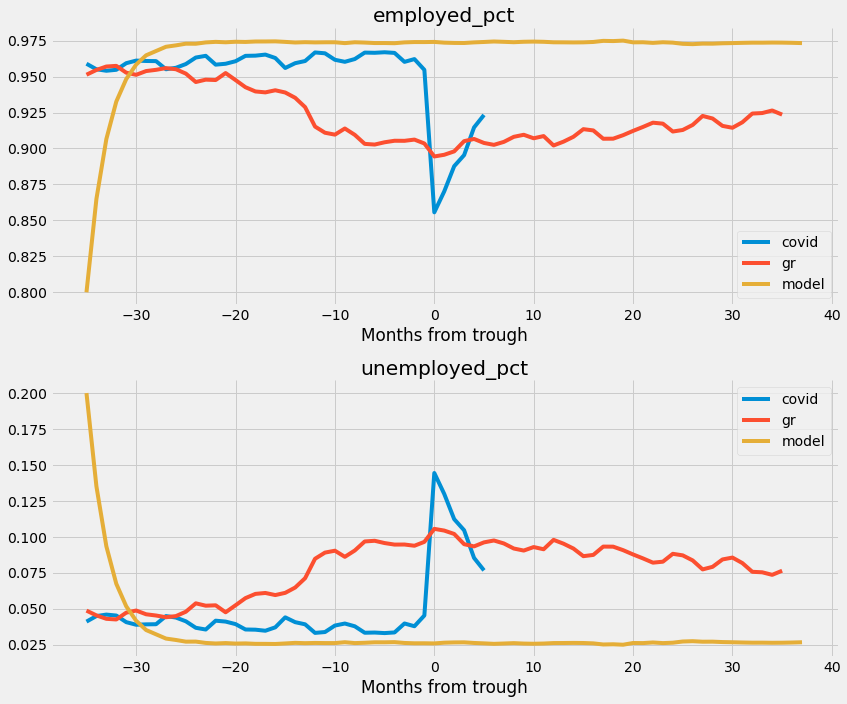

In [7]:
lm = LakeModelSimulator(s_0=np.array([0.2, 0.8]), N=150000)
df_sim = lm.combine_with_bls_data(
    lm.simulate_panel_fixed_alpha_beta(alpha_bar, beta_bar)
) 
plot_recession_data(df_sim);

Visually, we can see that the steady state version of this model does not match the features of either recession, which are:

- The COVID recession has an extremely sharp movement in the employment distribution
- The great recession featured a prolonged departure from pre-crisis levels

Our goal in this lecture is to discover deviations from $\alpha_t = \bar{\alpha}, \beta_t = \bar{\beta}\; \forall t$ that will allow the Lake model to do a better job of describing  times of stress in the US labor market

### Loss functions

Before looking at different assumptions about $\{\alpha_t, \beta_t \}$, we will first posit a **loss function**

A loss function is a deterministic function that measures the difference between a model's output and its target

The loss function is a key component to any statistical optimization routine and is heavily used  machine learning

We will use a very common loss function called the mean-squared-error loss function, or MSE

Given a sequence of targets and model outputs $\{y_i, \hat{y}_i\}_{i=1}^N$ the MSE is defined as

$$MSE(y, \hat{y}) = \frac{1}{N} \sum_{i=1}^N (y_i - \hat{y}_i)^2$$

For our current exercise, the model output will be the time series of percentage of workers that are employed

The target will be the correspoinding time-series from the BLS

We will compute the loss function indpendently for the great recession and COVID recession times

In [8]:
def compute_mse(df):
    """
    Given a DataFrame with columns ["months_from", "recession", and "employed_pct"],
    compute the MSE between model output and both great recession and COVID era
    unemployment data
    
    Parameters
    ----------
    df: pandas.DataFrame
        A DataFrame containing the unemployment BLS data and model output
    
    Returns
    -------
    mse: pandas.Series
        A pandas Series with `mse_gr` and `mse_covid` representing the MSE between
        model output and great recession data and COVID era data, repsectively
    """
    # set index so pandas will align data for us. Also multiply by 100 to move into
    # percentage units. This rescaling will make the MSE larger and easier to compare
    # across models
    _df = df.pivot(index="months_from", columns="recession", values="employed_pct") * 100
    return pd.Series(dict(
        mse_gr=_df.eval("(model - gr)**2").mean(),
        mse_covid=_df.eval("(model - covid)**2").mean()
    ))

In [9]:
compute_mse(df_sim)

mse_gr       34.397638
mse_covid    20.645996
dtype: float64

Using the loss function will allow us to move from qualitative to quantitative statements about the goodness of fit

For example, instead of saying 

> Model 2 appears to do better than model 1 at matching the spike in COVID era unemployment

we could say 

> The `mse_covid` for model 2 is 5.1 relative to 11.5 for model 1

## Model 1: one time shock to $s_t$

Consider the hypothesis that the COVID-19 spike in unemployment was only a shift of the employment/unemployment distribution ($s_0$), but didn't actually cause changes to the job creation ($\alpha$) or separation ($\beta$) rates

In term of our model parameters, this means

- $\alpha_t = \bar{\alpha}, \beta_t = \bar{\beta}\; \forall t$
- $s_0 = \bar{s}$, $s_t = \text{"shocked" } s$, where $t$ is date of shock
- $s_{\tau}$ with $\tau > t$ is dictated by $\bar{\alpha}$ and $\bar{\beta}$

> Note: for $\tau >> t$ we will have $s_{\tau} = \bar{s}$ again. This is what is meant by **steady state**, i.e.,  a place of rest according to the internal dynamics of the model. 

We have all the tools we need  to  inspect this hypothesis visually!

We'll follow these steps:


1. Set $s_0 = \bar{s}$
1. Set $\alpha_t = \bar{\alpha}, \beta_t = \bar{\beta}\; \forall t$
1. Simulate for first 35 periods (for $t = -35, \dots -1$)
1. At $t = 0$ set $s_t = [0.14, 0.86]$ which is approximately the peak level of unemployment in spring 2020 due to COVID-19
1. Simulate for $t = 0, \dots, 36$ starting from that point
1. Combine the 2 halfs of the simulation and plot

In [10]:
def simulate_single_shock(
        lm: LakeModelSimulator, 
        s_t: np.ndarray=np.array([0.14, 0.86])
    ):
    # Step 1 -- make sure s_0 is s_bar
    lm.s_0 = s_bar
    
    # Step 2 and 3 -- simulate for first 35 periods
    df_before = lm.simulate_panel_fixed_alpha_beta(alpha_bar, beta_bar, T=34)
    
    # Step 4 -- "shock" s_t. Note we do this by changing s_0
    # we'll adjust for the difference between timing `0` and `t` after
    # simulation
    lm.s_0 = s_t
    
    # Step 5 -- simulate for remainder of 35 periods
    df_after = lm.simulate_panel_fixed_alpha_beta(alpha_bar, beta_bar, T=35)
    df_after["months_from"] += 35
    
    # Step 6 -- combine simulation 1/2s
    out = pd.concat([df_before, df_after], ignore_index=True)  
    return lm.combine_with_bls_data(out)

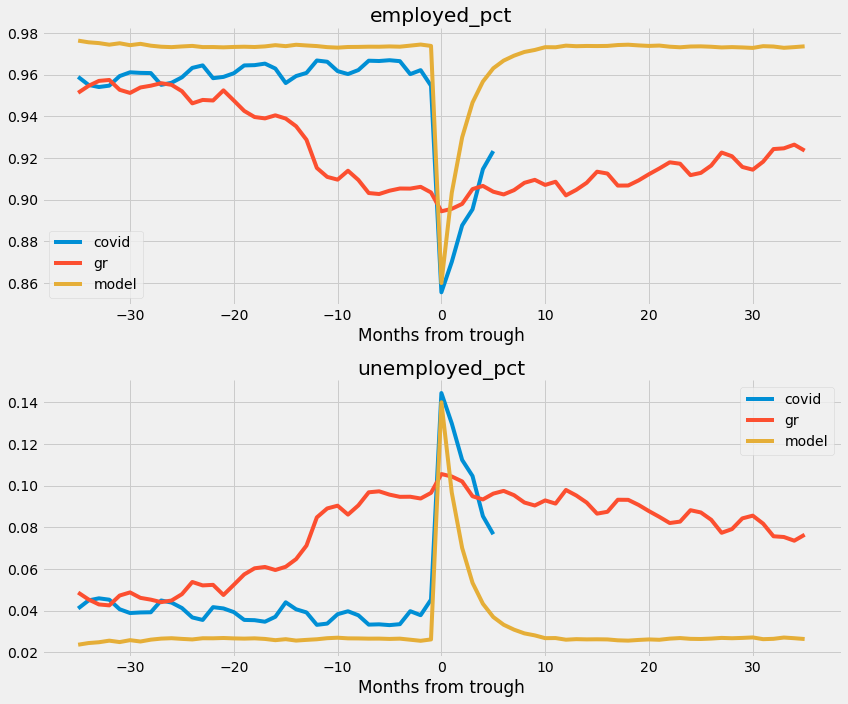

In [11]:
df_shock = simulate_single_shock(lm)
fig = plot_recession_data(df_shock);

Some things to notice:

- Up until the period after the shock, the model and COVID lines line up very closely
- The model seems to recover even faster than the data suggests the COVID recovery is happening
- The model recovers *much* faster than the great recession recovery, which says more about the difference between teh two recessions than anything else

The loss function for this model is

In [12]:
compute_mse(df_shock)

mse_gr       26.434085
mse_covid     3.728291
dtype: float64

As we might have expected, `mse_covid < mse_gr` because we forced the model to match the most extreme value of the COVID era recession

## Model 2: Single shock to $s_t$ and temporary shifts in $\alpha$, $\beta$

We just learned that our model is recovering even faster than actual COVID-era data

Perhaps the assumption that $\alpha$ and $\beta$ reamined constant is too strong...

Let's now relax that assumption, but in a disciplined way

We will assume that until the $t=0$ shock, $\alpha_t$ and $\beta_t$ are at their steady-state levels

Then, we assume that $s_t$ immediately jumps to the spiked COVID levels

Finally, we assume that  starting at zero and continuing temporarily for $N$ (a finite number of) periods, $\alpha$ and $\beta$ move to new values $\hat{\alpha}$ and $\hat{\beta}$

After  $N$ periods, $\alpha$ and $\beta$ return to $\bar{\alpha}$ and $\bar{\beta}$

Mathematically, these assumptions can be expressed as

\begin{align*}
\alpha_t &= \begin{cases}  \hat{\alpha} & 0 \le t \le N \\ \bar{\alpha} & \; \text{ else } \end{cases} \\
\beta_t &= \begin{cases} \hat{\beta} & 0 \le t \le N \\ \bar{\beta} & \; \text{ else } \end{cases} \\
\end{align*}

In [13]:
def simulate_alpha_beta_shock(
        lm: LakeModelSimulator,
        alpha_hat: float, 
        beta_hat: float, 
        N: int,
        s_t: np.ndarray=np.array([0.14, 0.86])
    ):
    # pre t=0 remains the same...
    lm.s_0 = s_bar
    df_before = lm.simulate_panel_fixed_alpha_beta(alpha_bar, beta_bar, T=34)
    
    # still shock at t=0
    lm.s_0 = s_t
    
    # prepare alpha_vec and beta_vec for t >=0 simulation
    alpha_vec = np.ones(35) * alpha_bar
    alpha_vec[:N] = alpha_hat
    
    beta_vec = np.ones(35) * beta_bar
    beta_vec[:N] = beta_hat
    
    # simulate using vector of alpha and beta
    df_after = lm.simulate_panel(alpha_vec, beta_vec)
    df_after["months_from"] += 35
    
    # combine simulation 1/2 and return
    out = pd.concat([df_before, df_after], ignore_index=True)
    return lm.combine_with_bls_data(out)


Now that we have this routine, let's test a version of the model where the job finding rate ($\alpha$) falls from 0.37 to 0.28  and the job separation rate ($\beta$) rises from 0.01 to 0.05

We'll suppose that this lasts for 3 periods

mse_gr       25.295254
mse_covid     2.415274
dtype: float64

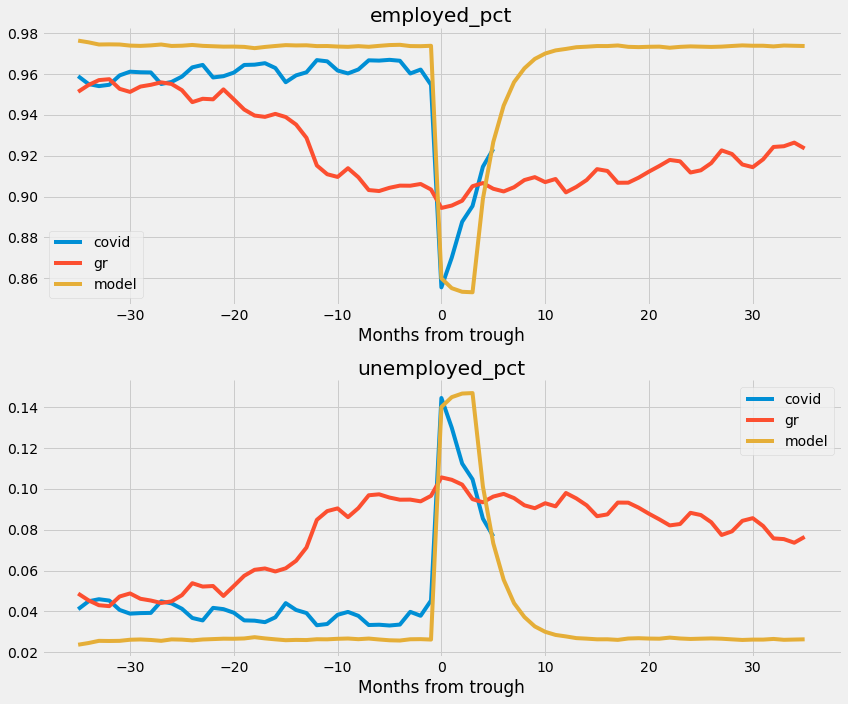

In [14]:
df_alpha_beta = simulate_alpha_beta_shock(lm, 0.28, 0.05, 3)
plot_recession_data(df_alpha_beta);
compute_mse(df_alpha_beta)

Our initial test values of $\hat{\alpha}$, $\hat{\beta}$, and $N$ did improve the `mse_covid` from about 4.0 to about 2.6

We chose these values informally (only using our intuition about what might have happened at the peak of the COVID era spike)

There are other values of these parameters that could have been better (lower `mse_covid`)

Let's assume the role of the "visual econometrician" and approximate superior values visually

In [15]:
from ipywidgets import interact, FloatSlider

def explore_alpha_beta_shock(alpha_hat: float, beta_hat:float , N: int):
    df_alpha_beta = simulate_alpha_beta_shock(lm, alpha_hat, beta_hat, N)
    plot_recession_data(df_alpha_beta);
    return compute_mse(df_alpha_beta)

interact(
    explore_alpha_beta_shock, 
    alpha_hat=FloatSlider(value=0.28, min=0.2, max=0.5, step=0.025),
    beta_hat=FloatSlider(value=0.05, min=0.01, max=0.2, step=0.01),
    N=3
)

interactive(children=(FloatSlider(value=0.28, description='alpha_hat', max=0.5, min=0.2, step=0.025), FloatSli…

<function __main__.explore_alpha_beta_shock(alpha_hat: float, beta_hat: float, N: int)>

In our experimenting, we found the following values to trace the "COVID recovery" quite well

- $\hat{\alpha} = 0.25$
- $\hat{\beta} = 0.02$
- $N = 4$

The `mse_covid` fell to about 1.7

## Model 3: shock to $\alpha_{t-1}$ and/or $\beta_{t-1}$

In our experiments thus far, we have moved $s_0$ by hand

We might want to answer the question, "What change in $\alpha$ and $\beta$ at period t-1 could have generated the drop in employment seen at time 0?"


### $\alpha_{-1}$ or $\beta_{-1}$?

In principle, either a decrease in the job finding rate or an increase in the job separation rate could lead to a decrease in the percentage of employed workers

Let's look specifically at the BLS data to for COVID era `months_from` -1 and 0 to identify the magnitude of the change in employment status

In [16]:
df_bls[["months_from", "recession", "employed_pct"]].query("months_from in [-1, 0] and recession=='covid'")

,months_from,recession,employed_pct
105,-1,covid,0.954656
106,0,covid,0.855586


#### Attempt 1: change $\alpha_{-1}$

Recall the steady-state job finding rate $\bar{\alpha}=0.37$ and job separation rate $\bar{\beta} = 0.01$

Suppose we believe that the change the employment data was driven entirely by a drop in the finding rate

Let's set $\alpha_{-1}$ to 0 and see what impact that has on $s_0$:

In [17]:
# number of employed workers at "m"inus 1
emp_m = 0.955

# move forward this percentage one period -- setting alpha to 0
emp_0_alpha = emp_m * (1-beta_bar) + 0 * (1-emp_m)

print("emp_0 when beta = beta_bar and alpha = 0:", emp_0_alpha)

emp_0 when beta = beta_bar and alpha = 0: 0.9454499999999999


This is far greater than the 0.855 from the BLS data

This shows that within the context of our model, the hypothesis that the drop in employment could not have come entirely from the job finding rate

#### Attempt 2: Change $\beta_{-1}$

Let's now consider a change in the job separation rate $\beta_{-1}$

Suppose we set this to 1 and keep $\alpha_{-1} = \bar{\alpha}$

In [18]:
# move forward this percentage one period -- setting alpha to 0
emp_0_beta = emp_m * (1-1) + alpha_bar * (1-emp_m)

print("emp_0 when beta_{-1} = 0 and alpha_{-1} = alpha_bar:", emp_0_beta)

emp_0 when beta_{-1} = 0 and alpha_{-1} = alpha_bar: 0.016650000000000015


This extreme value in the job separation rate puts time 0 employment down at 1.7%

This validates that it is *possible* (again within the context of our model) for a change in the job separation rate to be consistent with the BLS data

Let's now answer the question: "Keeping $\alpha_{-1} = \bar{\alpha}$, what value of $\beta_{-1}$ could generate a shift from 
0.954 of workers employed to 0.8555 workers employed?"

We'll call this value $\tilde{\beta}$ 

We can re-arrange the law of motion for the fraction of employed workers to solve for $\tilde{\beta}$:

$$\tilde{\beta} = 1 - \frac{e_0 - \bar{\alpha}(1-e_{-1})}{e_{-1}},$$

Where $e_t$ represents fraction of workers employed at time $t$

Let's compute this

In [19]:
emp_0 = 0.8556
beta_tilde = 1 - (emp_0 - alpha_bar*(1 - emp_m)) / emp_m
print("beta_tilde is: ", beta_tilde)

beta_tilde is:  0.12151832460732981


This suggests that in order for our model to generate the drop in employment observed in the COVID era, the job separation rate would need to move from the steady state value of 0.01 to 0.12

Thus, 12% of workers lost their jobs

Let's now simulate our model where we assume a one time shock to $\beta_{-1}$ and then an immediate return to $\bar{\beta}$

In [20]:
def simulate_one_time_beta_shock(
        lm: LakeModelSimulator, 
        beta_tilde: float
    ):
    # create vectors of alpha and beta
    lm.s_0 = s_bar
    alpha_vec = np.ones(71) * alpha_bar
    beta_vec = np.ones(71) * beta_bar
    
    # move only beta_{t-1} to beta_tilde
    beta_vec[34] = beta_tilde
    
    # simulate
    out = lm.simulate_panel(alpha_vec, beta_vec)
    return lm.combine_with_bls_data(out)

mse_gr       26.560086
mse_covid     3.957458
dtype: float64

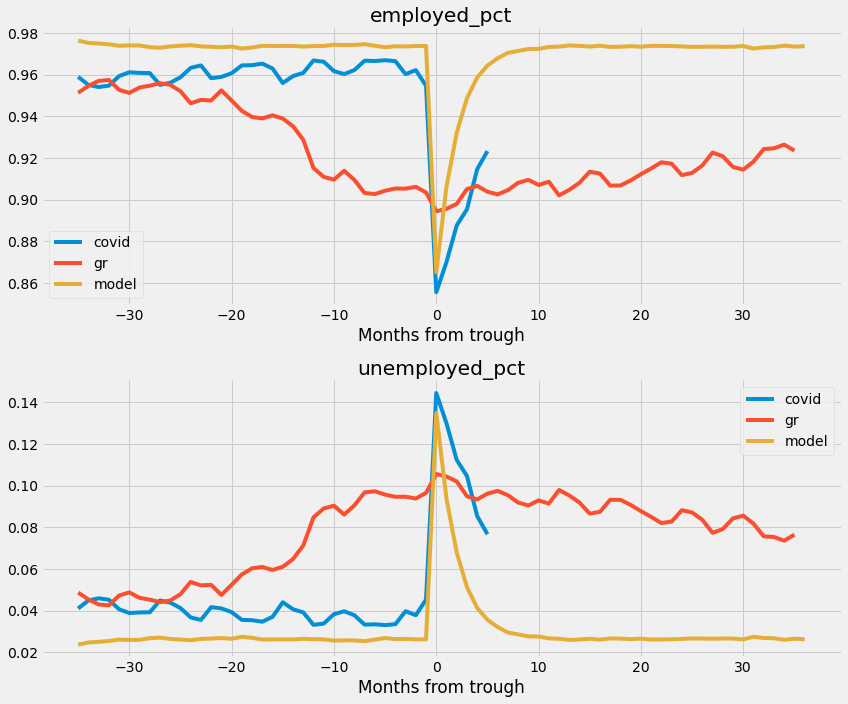

In [21]:
df_beta_shock = simulate_one_time_beta_shock(lm, beta_tilde)
plot_recession_data(df_beta_shock)
compute_mse(df_beta_shock)

This looks very similar to the original model in which supposed a one time shock to $s_0$...why?

We found the value of $\beta_{-1}$ that caused $s_0$ to equal the shocked value 

Then, we kept $\beta_t$ ($t \not= -1$) and $\alpha_t$ equal to their steady-state values

We allowed the model to *generate* the change in $s_0$ instead of imposing it

If the model outputs are the same, why could this be a desirable outcome?

Becuase the change in $s_0$ is coming from within the model, we can now do experiments like:

- Suppose the government could have saved 1/3 of the lost jobs in time 0. What impact would that have had on $s_t$, $t >=0$

In this sense we are able to use the model as a vehicle for doing counterfactual exercises

This idea captures the general spirit of computational social science: we build models that can capture a feature(s) of actual data we'd like to better understand so that we can analyze the impact of decisions on these variables of interest

## Model 4: Shock $\beta_{-1}$ and $\alpha_{t}$, $\beta_{t}$

In model 3 we were able to replicate the spike in COVID era unemployment

In model 2 (where we moved $\alpha_t$ and $\beta_{t}\; t = 0, \dots N$) we were able to replicate the first few periods of the recovery

Let's combine these two to have a single model that can match the COVID era labor market dynamics

In [22]:
def shock_beta_m_and_alpha_beta(
        lm: LakeModelSimulator,
        beta_tilde: float,
        alpha_hat: float, 
        beta_hat: float, 
        N: int,
    ):
    # create vectors of alpha and beta
    lm.s_0 = s_bar
    alpha_vec = np.ones(71) * alpha_bar
    beta_vec = np.ones(71) * beta_bar
    
    # move beta_{t-1} to beta_tilde
    beta_vec[34] = beta_tilde
    
    # move alpha_0 to alpha_N to alpha_hat
    alpha_vec[35:(35+N)] = alpha_hat
    
    # same for beta
    beta_vec[35:(35+N)] = beta_hat
    
    out = lm.simulate_panel(alpha_vec, beta_vec)
    return lm.combine_with_bls_data(out)
    

We'll use the values found above: 

\begin{align*}
\tilde{\beta} &= 0.12 \\
\hat{\beta} &= 0.02 \\ 
\hat{\alpha} &= 0.25 \\
N &= 4
\end{align*}

mse_gr       24.503396
mse_covid     1.631113
dtype: float64

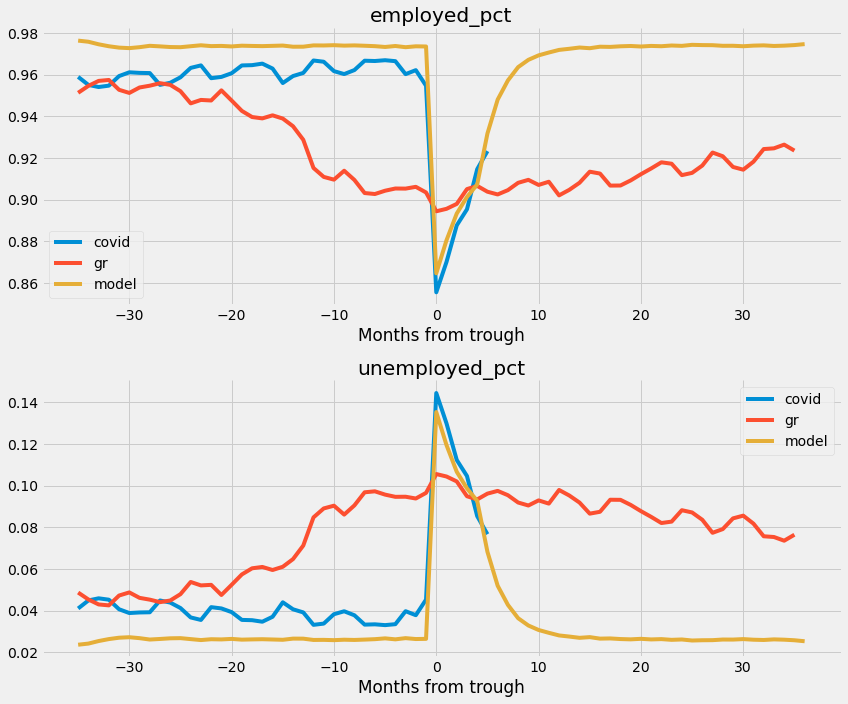

In [23]:
df_betam_and_alpha_beta = shock_beta_m_and_alpha_beta(lm, beta_tilde, 0.25, 0.02, 4)
plot_recession_data(df_betam_and_alpha_beta)
compute_mse(df_betam_and_alpha_beta)

## Model 5: Time varying $\alpha_t$ and $\beta_t$

Our analysis has focused on models where $\alpha$ and $\beta$ are at their steady state values, except for a few periods

This may be reasonable for the very sharp COVID era activity, but less reasonable for the great recession era

The great recession featured a prolonged, gradual increase in unemployment and then a slow decline

In order for our model to achieve something like this, we would need to allow $\alpha_t$ and $\beta_t$ to be different from their steady state values for multiple periods

Let's now turn to the question of "What values of $\alpha_t$ and $\beta_t$, for $t \in [-35, 35]$ could generate great recession era dynamics?"

The `df_bls` DataFrame has columns `ee`, `eu`, `ue`, and `uu`

These represent rates of individuals moving between employment and unemployment status (based on first letter of each word)

The `ue` and `eu` map very closely into our $\alpha$ and $\beta$

We'll treat them as a time series of $\alpha_t$ and $\beta_t$, respectively as we simulate our Lake model

In [24]:
def simulate_great_recession(
        lm: LakeModelSimulator,
        df_bls: pd.DataFrame,
        s_init: np.ndarray,
    ):
    df_gr = df_bls.query("recession == 'gr'").sort_values("months_from")
    alpha_vec = df_gr["ue"].to_numpy()
    beta_vec = df_gr["eu"].to_numpy()
    lm.s_0 = s_init
    out = lm.simulate_panel(alpha_vec, beta_vec)
    return lm.combine_with_bls_data(out)

mse_gr       0.533506
mse_covid    8.576246
dtype: float64

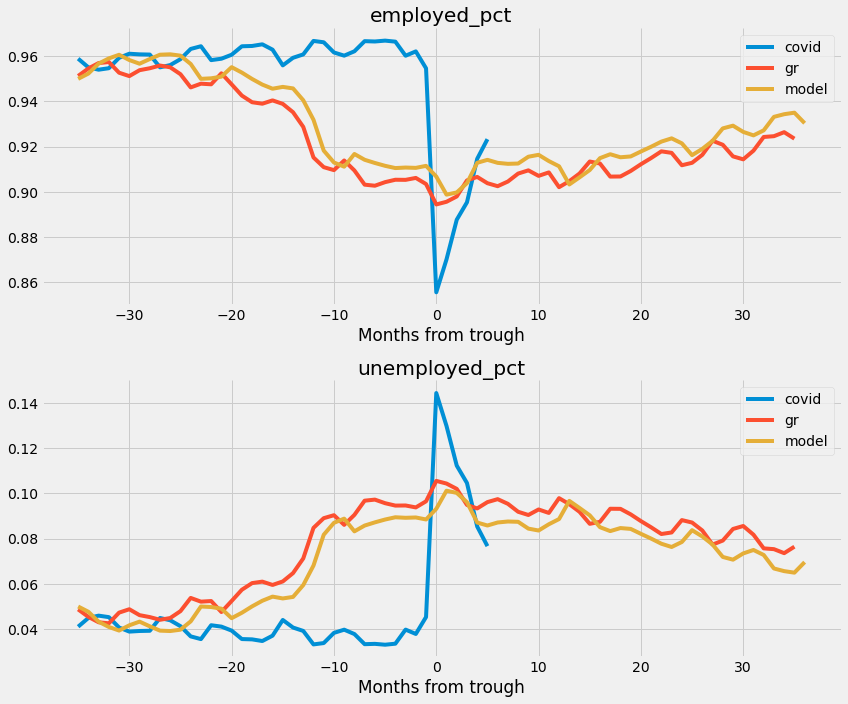

In [25]:
# set initial state for great recession times
s_init_gr = [0.05, 0.95]
df_model_gr = simulate_great_recession(lm, df_bls, s_init_gr)
plot_recession_data(df_model_gr)
compute_mse(df_model_gr)

Notice now that our model can track the labor market dynamics in teh great recession era quite well; `mse_gr` is down to 0.51

However the `mse_covid` has risen to 9.05

This illustrates a common curse (and blessing!) to all modeling exercsies: modeling decisions comes with tradeoffs

Our two state markov chain view of labor market fluctuations cannot match both the great recession era and the COVID era

The blessing in disguise is

- We must be delibrate in specifying our modeling goals: do we want to match great recession era dynamics or COVID era dynamics?
- We can afford to use simpler models:  we want the simplest model that allows us to achieve the modeling goal

### Looking ahead

Why go through the trouble of building models?

As social scientists, we rarely have the luxury of setting up controlled experiments

The nature of our subject of study -- society and people -- does not allow for easy, controlled testing of hypothesis

So, in order to employ the scientific method, we must create for ourselves a laboratory

We use laboratories constructed of mathematical equation and statistical structure

A model allows us to consider "what if" scenarios, often called counterfactuals

In these scenarios we can evaluate the tradeoffs of potential policy decisions

For example, our Lake model could be the labor market piece of a larger economic framework

This larger framework could include 

- Household decisions like saving vs. spending
- A government that must raise taxes and enact policies for labor market relief
- International trading partners that can increase diversity of goods and smooth out labor shocks

Building up a rich framework by connecting well-understood pieces allows us to make a change in one component (e.g. government spending to subsidise labor market) and see the corresponding impact on other parts of the economy (e.g. a lower separation rate and increased household consumption/welfare)

Throughout this course we will put our data, programming, math, modeling tools to work to build models and perform experiments like this